## Notebook Summary: 3GPP Chunk Embedding & Visualization

This notebook prepares 3GPP Release 15 and 16 documents for use in a centralized RAG system for telecom-specific QA. It performs the following steps:

1. **Cleaning & Chunking**: Parses markdown files, removes boilerplate content, and splits cleaned text into overlapping word chunks (256 words, 64 overlap).

2. **Embedding**: Generates semantic embeddings using `all-MiniLM-L6-v2` from SentenceTransformers.

3. **Visualization**: Applies PCA and UMAP to project embeddings in 2D, with points colored by release (Rel-15 / Rel-16) to observe semantic distribution.

4. **Indexing**: Builds a FAISS index with cosine similarity for fast chunk retrieval.

5. **Export**: Saves the index and chunk metadata for use in downstream RAG-based QA with LLaMA-2.

This step is essential for enabling fast, relevant retrieval of telecom knowledge chunks during inference in the centralized RAG setup, supporting the thesis focus on domain-specific LLM personalization.

In [ ]:
# Centralized RAG Setup for 3GPP Markdown Docs


# STEP 1 — Install Required Libraries
# !pip install faiss-cpu sentence-transformers markdown beautifulsoup4 --quiet

In [1]:
# STEP 2 — Imports and Configuration
from pathlib import Path
from markdown import markdown
from bs4 import BeautifulSoup
import re
import numpy as np
import pickle
import faiss
from sentence_transformers import SentenceTransformer

# Define folder paths for 3GPP releases
RELEASE_DIRS = [f"/mnt/data/TSpec-LLM/3GPP-clean/Rel-{r}" for r in range(15, 17)]

# Chunking config
CHUNK_SIZE = 256
CHUNK_OVERLAP = 64

In [3]:
md_count = 0
for folder in RELEASE_DIRS:
    for file in Path(folder).rglob("*.md"):
        md_count += 1
print(f"📂 Total markdown files found: {md_count}")

📂 Total markdown files found: 3293


In [4]:
# STEP 3 — Clean & Preprocess Markdown Text

def is_irrelevant_paragraph(p: str):
    p = p.lower().strip()
    return any([
        "3gpp ts" in p,
        "etsi" in p,
        "keywords:" in p,
        "copyright" in p,
        "all rights reserved" in p,
        "release" in p and "version" in p,
        p.isdigit(),                         # bare page or TOC numbers
        len(p) < 10 and p.endswith("."),     # line fragments
        p.startswith("!")                    # image markdown
    ])

def clean_md(md_text):
    """Clean markdown: remove boilerplate, insert section markers."""
    html = markdown(md_text)
    soup = BeautifulSoup(html, "html.parser")

    # Insert section breaks after major headers
    for tag in soup.find_all(['h1', 'h2', 'h3']):
        tag.insert_after("SECTION_BREAK")

    lines = soup.get_text().split("\n")
    filtered = [line for line in lines if not is_irrelevant_paragraph(line)]
    text = "\n".join(filtered)

    # Mark logical sections for optional use
    text = re.sub(r"SECTION_BREAK", "\n\n", text)
    return re.sub(r"\s+", " ", text).strip()

In [5]:
# STEP 4 — Chunking Strategy

def chunk_text(text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP):
    """Split text into overlapping word-based chunks."""
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i + chunk_size])
        if len(chunk.split()) >= 30:
            chunks.append(chunk)
    return chunks

In [6]:
# STEP 5 — Document Parsing Pipeline
documents = []

for folder in RELEASE_DIRS:
    for file in Path(folder).rglob("*.md"):
        if "annex" in file.stem.lower() or "appendix" in file.stem.lower():
            continue  # Skip appendices

        with open(file, "r", encoding="utf-8") as f:
            raw = f.read()
            clean = clean_md(raw)
            chunks = chunk_text(clean)

            for chunk in chunks:
                documents.append({
                    "content": chunk,
                    "source": str(file)
                })

print(f"✅ Loaded and chunked {len(documents)} chunks from .md files.")

✅ Loaded and chunked 655836 chunks from .md files.


In [ ]:
# from tqdm import tqdm

# # STEP 5 — Document Parsing with Progress & Stats
# documents = []
# chunk_stats = []  #  For logging per-file chunk count

# # Gather all .md file paths (recursively)
# md_files = []
# for folder in RELEASE_DIRS:
#     md_files.extend(Path(folder).rglob("*.md"))

# print(f" Total markdown files to process: {len(md_files)}")

# # Parse, clean, chunk with tqdm
# for file in tqdm(md_files, desc=" Chunking files"):
#     if "annex" in file.stem.lower() or "appendix" in file.stem.lower():
#         continue

#     with open(file, "r", encoding="utf-8") as f:
#         raw = f.read()
#         clean = clean_md(raw)
#         chunks = chunk_text(clean)

#         for chunk in chunks:
#             documents.append({
#                 "content": chunk,
#                 "source": str(file)
#             })

#         #  Track per-file chunk counts
#         chunk_stats.append((file.name, len(chunks)))

# print(f"\n Total chunks created: {len(documents)}")

# # STEP 5.1 — Optional: Print top chunk-heavy files
# chunk_stats.sort(key=lambda x: x[1], reverse=True)
# print("\n Top files by chunk count:")
# for fname, count in chunk_stats[:5]:
#     print(f"🔹 {fname}: {count} chunks")

# import pandas as pd

# df = pd.DataFrame(chunk_stats, columns=["filename", "chunk_count"])
# df.to_csv("/mnt/data/chunk_stats.csv", index=False)
# print(" Chunk stats saved to chunk_stats.csv")

In [7]:
# STEP 6 — Embed Using SentenceTransformer (MiniLM)
print(" Encoding chunks with MiniLM...")
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(
    [doc["content"] for doc in documents],
    normalize_embeddings=True,
    show_progress_bar=True
)

🔍 Encoding chunks with MiniLM...


Batches:   0%|          | 0/20495 [00:00<?, ?it/s]

In [8]:
import random
import numpy as np

# Sample 2000 chunks randomly
SAMPLE_SIZE = 2000
sample_indices = random.sample(range(len(embeddings)), SAMPLE_SIZE)

sample_embeds = np.array([embeddings[i] for i in sample_indices])
sample_texts = [documents[i]["content"][:80] + "..." for i in sample_indices]  # preview for tooltips

📉 Performing PCA...


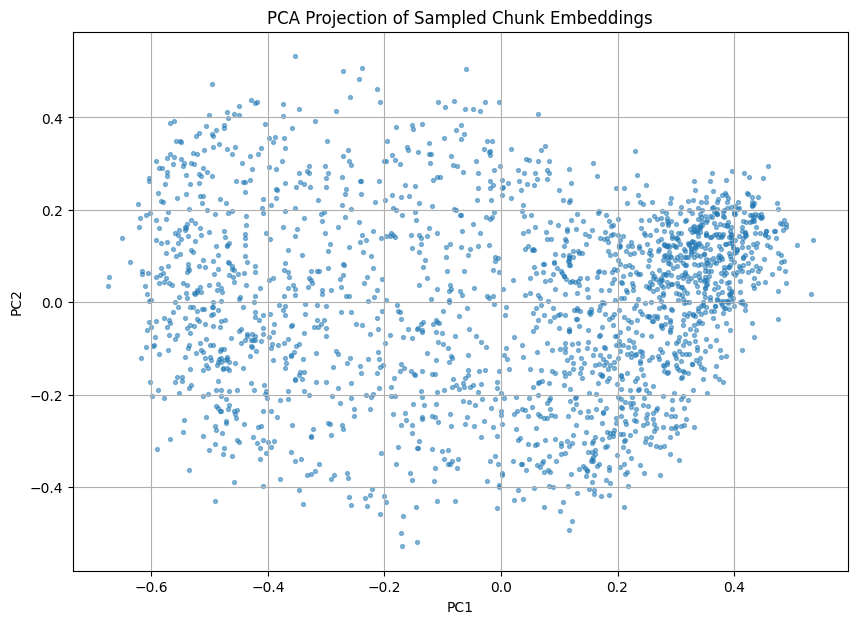

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("📉 Performing PCA...")
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(sample_embeds)

plt.figure(figsize=(10, 7))
plt.scatter(pca_proj[:, 0], pca_proj[:, 1], alpha=0.5, s=8)
plt.title("PCA Projection of Sampled Chunk Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

🌌 Performing UMAP...


/home/ec2-user/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


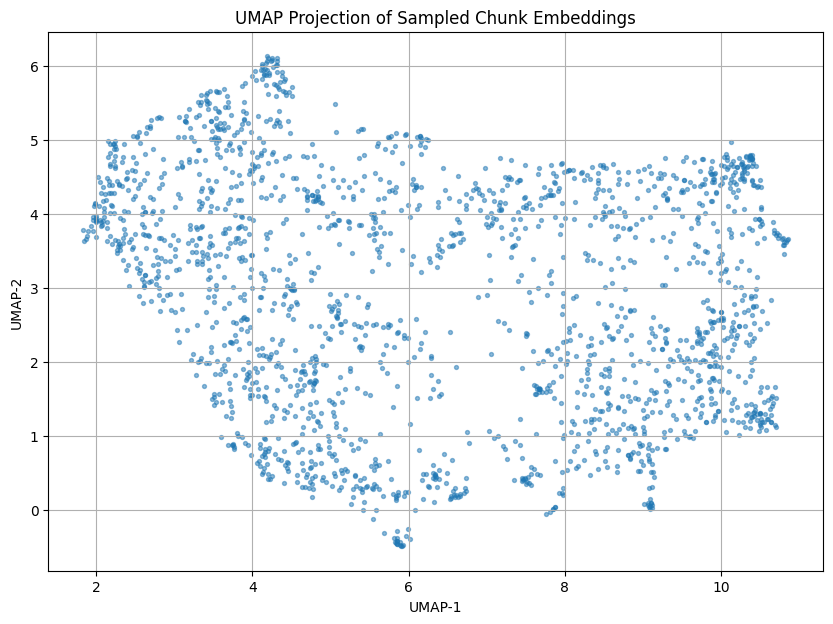

In [12]:
import umap

print("🌌 Performing UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42)
umap_proj = reducer.fit_transform(sample_embeds)

plt.figure(figsize=(10, 7))
plt.scatter(umap_proj[:, 0], umap_proj[:, 1], alpha=0.5, s=8)
plt.title("UMAP Projection of Sampled Chunk Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

In [13]:
import pandas as pd

df = pd.DataFrame({
    "text_preview": sample_texts,
    "pca_x": pca_proj[:, 0],
    "pca_y": pca_proj[:, 1],
    "umap_x": umap_proj[:, 0],
    "umap_y": umap_proj[:, 1]
})
df.to_csv("/mnt/data/RAG/embedding_projections.csv", index=False)
print("✅ Projection saved to embedding_projections.csv")

✅ Projection saved to embedding_projections.csv


In [15]:
import random
import numpy as np

# Sample 2000 chunks randomly
SAMPLE_SIZE_n = 2000
sample_releasess = []
for i in sample_indices:
    path = documents[i]["source"]
    release = next(part for part in path.split("/") if "Rel-" in part)
    sample_releasess.append(release)
sample_texts = [documents[i]["content"][:80] + "..." for i in sample_indices]  # preview for tooltips

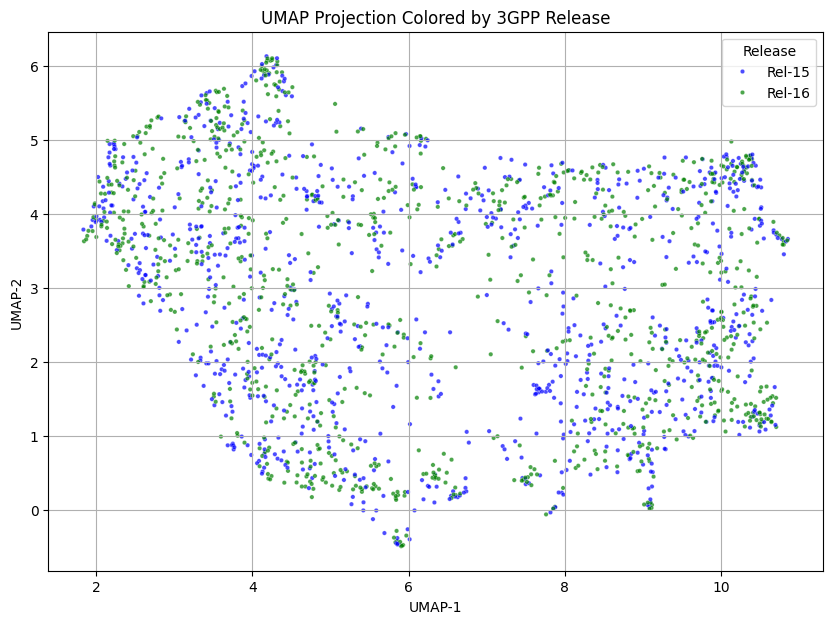

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map each release to a color
palette = {"Rel-15": "blue", "Rel-16": "green"}
colors = [palette[r] for r in sample_releasess]

plt.figure(figsize=(10, 7))
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=sample_releasess, palette=palette, s=10, alpha=0.7)
plt.title("UMAP Projection Colored by 3GPP Release")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Release")
plt.grid(True)
plt.show()

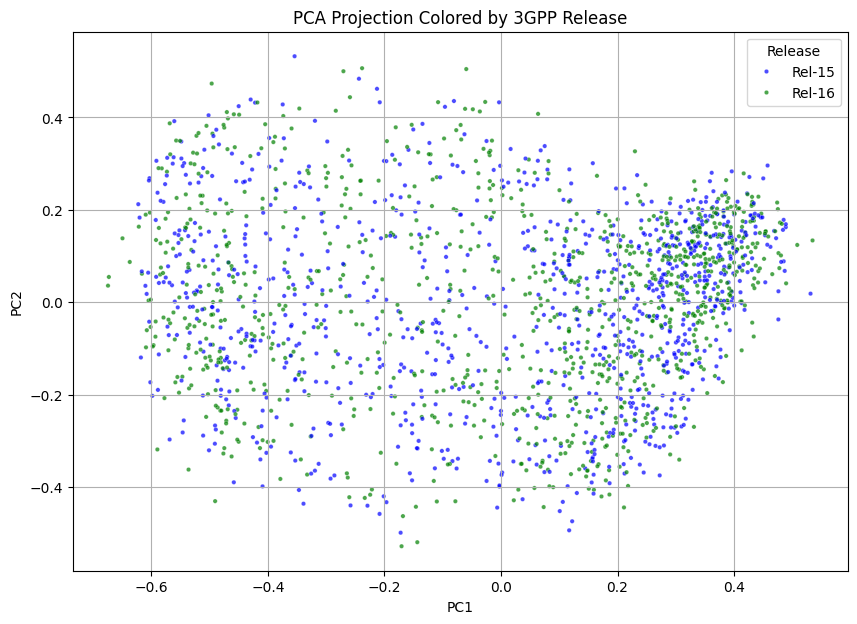

In [18]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_proj[:, 0], y=pca_proj[:, 1], hue=sample_releasess, palette=palette, s=10, alpha=0.7)
plt.title("PCA Projection Colored by 3GPP Release")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Release")
plt.grid(True)
plt.show()

In [19]:
# STEP 7 — FAISS Index (Cosine Similarity)
dimension = embeddings[0].shape[0]
index = faiss.IndexFlatIP(dimension)
index.add(np.array(embeddings).astype("float32"))

In [20]:
# STEP 8 — Save Outputs
faiss.write_index(index, "/mnt/data/RAG/3gpp_index.faiss")
with open("/mnt/data/RAG/3gpp_chunks.pkl", "wb") as f:
    pickle.dump(documents, f)

print("✅ FAISS index and metadata saved to /mnt/data/")

✅ FAISS index and metadata saved to /mnt/data/


In [21]:
# STEP 9 — Retrieval Function
def retrieve(query, top_k=3):
    query_emb = model.encode([query], normalize_embeddings=True)
    D, I = index.search(np.array(query_emb).astype("float32"), top_k)
    return [documents[i] for i in I[0]]

In [22]:
# STEP 10 — Test Query
query = "What procedures does the AMF follow when handling a mobility event during an active PDU session?"
results = retrieve(query, top_k=3)

for i, r in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(f"Source: {r['source']}")
    print(r['content'])


--- Result 1 ---
Source: /mnt/data/TSpec-LLM/3GPP-clean/Rel-16/23_series/23502-gh0.md
the new AMF behaves as follows: - If the UE has only an emergency PDU Session, the AMF either skips the authentication and security procedure in step 7 or accepts that the authentication may fail and continues the Mobility Registration Update procedure; or - If the UE has both emergency and non emergency PDU Sessions and authentication fails, the AMF continues the Mobility Registration Update procedure and deactivates all the non-emergency PDU Sessions as specified in clause 4.3.4.2. NOTE 2: The new AMF can determine if a PDU Session is used for emergency service by checking whether the DNN matches the emergency DNN. 7. [Conditional] If the AMF determines to initiate the authentication procedure to the UE in step 6b (e.g. the AMF can not obtain the UE MM context from AMF or other reasons), steps 8-9 of clause 4.2.2.2.2 are optionally performed. 7a. In the case of idle mode mobility, the AMF decide wh

In [23]:
# STEP 10 — Test Query
query = "How is the security key hierarchy structured between the gNB and UE in 5G NR according to Release 16?"
results = retrieve(query, top_k=3)

for i, r in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(f"Source: {r['source']}")
    print(r['content'])


--- Result 1 ---
Source: /mnt/data/TSpec-LLM/3GPP-clean/Rel-16/33_series/33807-g01.md
in the architecture. 5G-RG acts as a 5G UE in order to access 5GC reusing security procedure defined in TS 33.501 [3]. The scenario of UE behind 5G-RG accesses to the 5GC is also captured in the present document. The security of FN-RG accessing to 5GC is studied in the present document. The scenario of UE behind FN-RG accesses to the 5GC is also captured in the present document. For trusted non-3GPP access, the unified authentication framework is reused. Any potential security enhancements in addition to the security procedures defined in TS 33.501 [3] are captured in the present 5 Key issues 5.1 Key Issue #1: security of 5G-RG 5.1.1 Key issue details 5G RG is a new introduced entity in TR 23.716 [2] for 5WWC service. According to the definition of 5G RG, it is both a RG connecting to 5GC and some kind of relay for forwarding the messages from a 5GC capable UE behind it. Therefor the 5G RG has differ

In [24]:
# STEP 10 — Test Query
query = "What positioning techniques are supported in 5G NR for Release 16 and how do they differ from Release 15?"
results = retrieve(query, top_k=3)

for i, r in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(f"Source: {r['source']}")
    print(r['content'])


--- Result 1 ---
Source: /mnt/data/TSpec-LLM/3GPP-clean/Rel-16/38_series/38855-g00.md
on positioning use cases in indoor and outdoor environments. The technical report [7] complements existing work on 5G use cases involving positioning needs in order to identify potential requirements for 5G positioning services. The document further develops the identified use cases by providing some considerations on the suitability of positioning technologies to these use cases. The following requirements were captured in [8]. NR should enable, and improve if suitable, state-of-art positioning techniques, such as RAN-embedded (Cell-ID, E-Cell ID, DL-TDOA, UL-TDOA, etc.) and RAN-external (GNSS, Bluetooth, WLAN, Terrestrial Beacon Systems (TBS), sensors, etc.). NR positioning shall exploit high bandwidth, massive antenna systems, network architecture/ functionalities (e.g. heterogeneous networks, broadcast, MBMS) and deployment of massive number of devices. NR positioning shall support indoors and ou

In [25]:
# STEP 10 — Test Query
query = "How does a UE register for a specific network slice in 5G according to Release 15?"
results = retrieve(query, top_k=3)

for i, r in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(f"Source: {r['source']}")
    print(r['content'])


--- Result 1 ---
Source: /mnt/data/TSpec-LLM/3GPP-clean/Rel-15/22_series/22261-f90.md
allow the operator to configure the information which associates a UE to a network slice. The 5G system shall allow the operator to configure the information which associates a service to a network slice. The 5G system shall allow the operator to assign a UE to a network slice, to move a UE from one network slice to another, and to remove a UE from a network slice based on subscription, UE capabilities, the access technology being used by the UE, operator\'s policies and services provided by the network slice. The 5G system shall support a mechanism for the VPLMN to assign a UE to a network slice with the needed services and authorised by the HPLMN, or to a default network slice. The 5G system shall enable a UE to be simultaneously assigned to and access services from more than one network slice of one operator. Traffic and services in one network slice shall have no impact on traffic and services in

In [26]:
# Step A: Parse Only Annex/Appendix Files
annex_documents = []

for folder in RELEASE_DIRS:
    for file in Path(folder).rglob("*.md"):
        if "annex" in file.stem.lower() or "appendix" in file.stem.lower():
            with open(file, "r", encoding="utf-8") as f:
                raw = f.read()
                clean = clean_md(raw)
                chunks = chunk_text(clean)

                for chunk in chunks:
                    annex_documents.append({
                        "content": chunk,
                        "source": str(file)
                    })

print(f"✅ Loaded and chunked {len(annex_documents)} ANNEX chunks.")

✅ Loaded and chunked 16584 ANNEX chunks.


In [27]:
# Step B: Embed Annex Chunks
annex_embeddings = model.encode(
    [doc["content"] for doc in annex_documents],
    normalize_embeddings=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/519 [00:00<?, ?it/s]

In [28]:
# Step C: Add to Existing FAISS Index
index.add(np.array(annex_embeddings).astype("float32"))

# Step D: Merge Document Metadata
documents.extend(annex_documents)

In [29]:
# Step E: Re-save Combined Index and Metadata
faiss.write_index(index, "/mnt/data/RAG/3gpp_index.faiss")
with open("/mnt/data/RAG/3gpp_chunks.pkl", "wb") as f:
    pickle.dump(documents, f)

print("✅ FAISS index and metadata (incl. ANNEX) updated and saved.")

✅ FAISS index and metadata (incl. ANNEX) updated and saved.


In [30]:
# STEP 10 — Test Query
query = "How is the security key hierarchy structured between the gNB and UE in 5G NR according to Release 16?"
results = retrieve(query, top_k=3)

for i, r in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(f"Source: {r['source']}")
    print(r['content'])


--- Result 1 ---
Source: /mnt/data/TSpec-LLM/3GPP-clean/Rel-16/33_series/33807-g01.md
in the architecture. 5G-RG acts as a 5G UE in order to access 5GC reusing security procedure defined in TS 33.501 [3]. The scenario of UE behind 5G-RG accesses to the 5GC is also captured in the present document. The security of FN-RG accessing to 5GC is studied in the present document. The scenario of UE behind FN-RG accesses to the 5GC is also captured in the present document. For trusted non-3GPP access, the unified authentication framework is reused. Any potential security enhancements in addition to the security procedures defined in TS 33.501 [3] are captured in the present 5 Key issues 5.1 Key Issue #1: security of 5G-RG 5.1.1 Key issue details 5G RG is a new introduced entity in TR 23.716 [2] for 5WWC service. According to the definition of 5G RG, it is both a RG connecting to 5GC and some kind of relay for forwarding the messages from a 5GC capable UE behind it. Therefor the 5G RG has differ